# Particle plots

This notebook shows how to plot the concentrations for multiple particles along the thickness of each electrode.

If this notebook is running on Google Colab, we first need to install PyBaMM (you can skip if not using Google Colab).

In [1]:
%pip install pybamm -q

You should consider upgrading via the '/home/ferranbrosa/continuum-model-review/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We start by defining the simulation of the DFN model.

In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

pybamm.set_logging_level("INFO")

# load model
model = pybamm.lithium_ion.DFN()
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
# param = model.default_parameter_values
param = pybamm.ParameterValues(chemistry="Chen2020")
param.process_geometry(geometry)
param.process_model(model)

# set mesh
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 30, var.x_s: 30, var.x_p: 30, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# solve model
t_eval = np.linspace(0, 3600, 100)
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)
solution = solver.solve(model, t_eval)

# plot
plot = pybamm.QuickPlot(
    solution,
    [
        "Negative particle concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Positive particle concentration [mol.m-3]",
        "Current [A]",
        "Negative electrode potential [V]",
        "Electrolyte potential [V]",
        "Positive electrode potential [V]",
        "Terminal voltage [V]",
    ],
    time_unit="seconds",
    spatial_unit="um",
)

2022-06-10 17:45:19,406 - [INFO] base_battery_model.build_model(834): Start building Doyle-Fuller-Newman model
2022-06-10 17:45:19,519 - [INFO] base_battery_model.build_model(854): Finish building Doyle-Fuller-Newman model
2022-06-10 17:45:19,569 - [INFO] parameter_values.process_model(416): Start setting parameters for Doyle-Fuller-Newman model
2022-06-10 17:45:19,717 - [INFO] parameter_values.process_model(518): Finish setting parameters for Doyle-Fuller-Newman model
2022-06-10 17:45:19,721 - [INFO] discretisation.process_model(137): Start discretising Doyle-Fuller-Newman model
2022-06-10 17:45:20,418 - [INFO] discretisation.process_model(254): Finish discretising Doyle-Fuller-Newman model
2022-06-10 17:45:20,419 - [INFO] base_solver.solve(815): Start solving Doyle-Fuller-Newman model with CasADi solver with 'safe' mode
2022-06-10 17:45:20,426 - [INFO] base_solver.set_up(111): Start solver set-up
2022-06-10 17:45:20,620 - [INFO] base_solver.set_up(678): Finish solver set-up
2022-06-1

Now we define `plot_particles` which given a variable it generates a plot of it across the particles in each electrode

In [3]:
def plot_particles(phi, Nr=100):
    r"""
    Plot the particles of radius r and variables phi

    Parameters
    ----------
    phi : (float)
        Array of variable phi to plot as function of r starting rx=0 and
        ending at rx=r. Shape [Np, Nr]

    Returns
    -------
    None.

    """
    Np, _ = np.shape(phi)
    fig, ax = plt.subplots(1, 1, figsize=(Np * 5, 5))
    length = 2 * Nr
    im = np.ones([length, Np * length])
    for p in range(Np):
        im[:, length * p : length * (p+1)] = color_particle(phi[p, :])
        
    mappable = ax.imshow(im, cmap="coolwarm")
    plt.colorbar(mappable)
    plt.tight_layout

def color_particle(phi, Nr=100):
    r"""
    Color a particle of radius with a vector of variable phi

    Parameters
    ----------
    phi : (float)
        Array of variable phi to plot as function of r starting rx=0 and
        ending at rx=r. Shape [Nr]

    Returns
    -------
    phi_map: np.ndarray [2*Nr, 2*Nr]

    """

    N = 2 * len(phi)
    im = np.indices([2*Nr, 2*Nr]).astype(float)
    im -= Nr
    r_map = np.sqrt(im[0, :, :] ** 2 + im[1, :, :] ** 2)
    r_map[r_map > Nr] = np.nan
    f = interp1d(np.linspace(0, Nr, len(phi)), phi)
    return f(r_map)

Finally, we can generate the plots for various number of particles and times

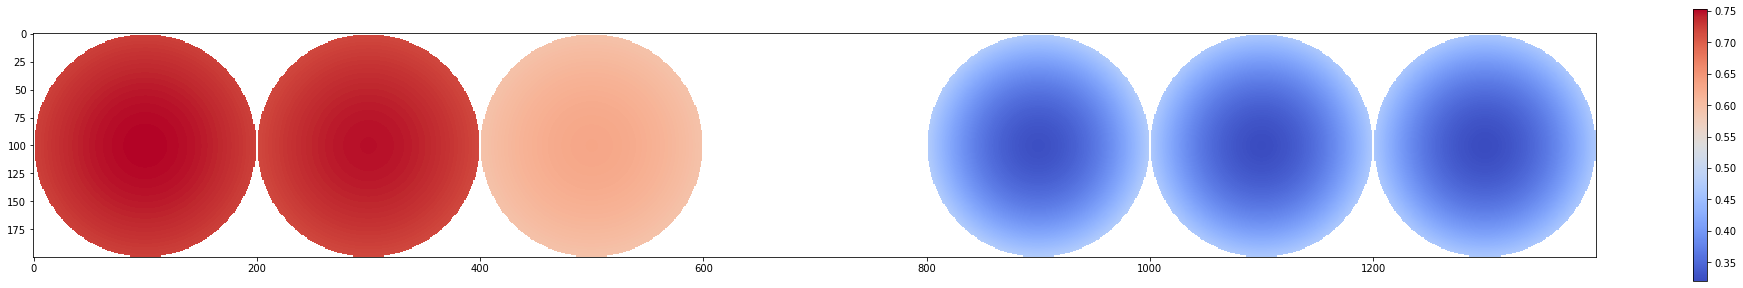

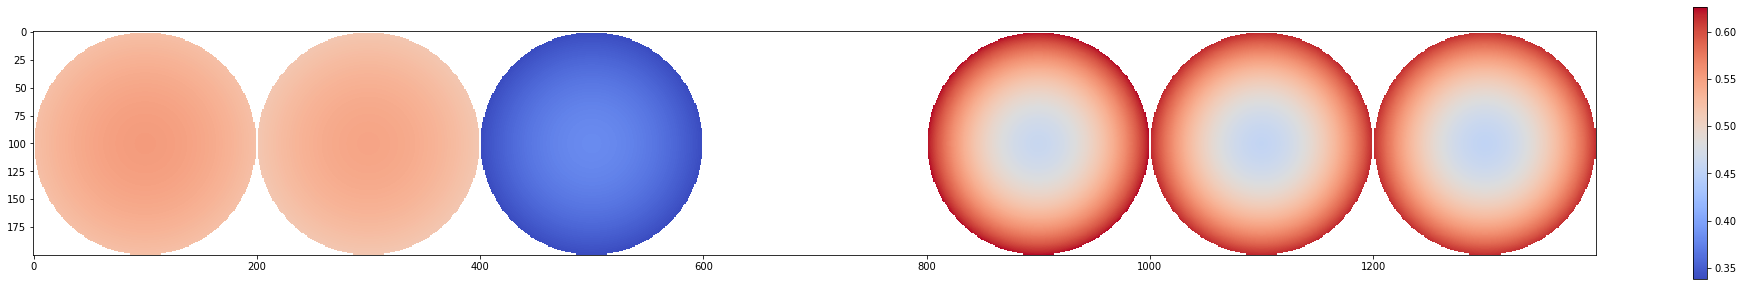

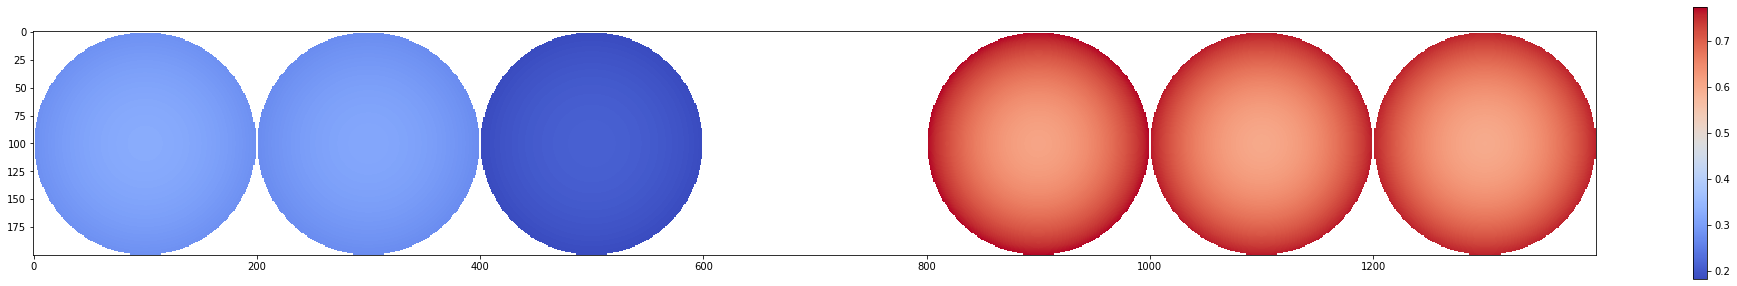

In [4]:
for tstep in [25, 50, 75]:
    C_n = solution["Negative particle concentration"].entries[:, :, tstep].T
    C_p = solution["Positive particle concentration"].entries[:, :, tstep].T
    C_s = C_n[:1, :] * np.nan
    dom = np.vstack((C_n[[0, 5, -1], :], C_s, C_p[[0, 5, -1], :]))
    plot_particles(dom)

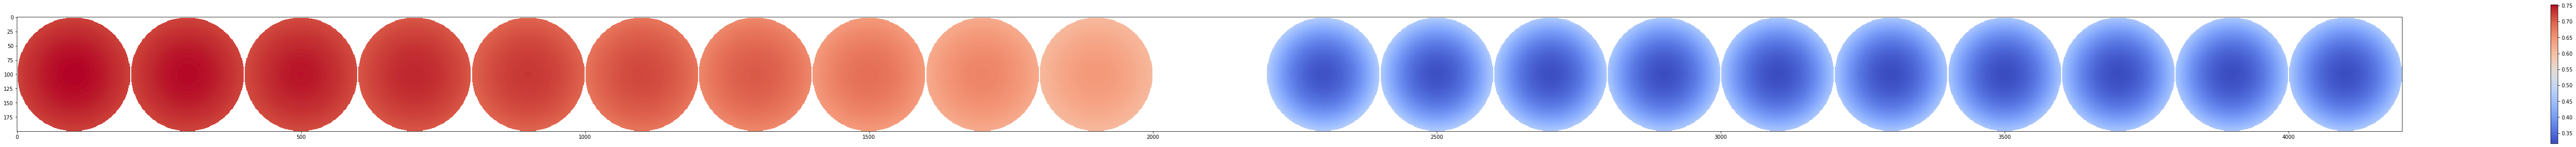

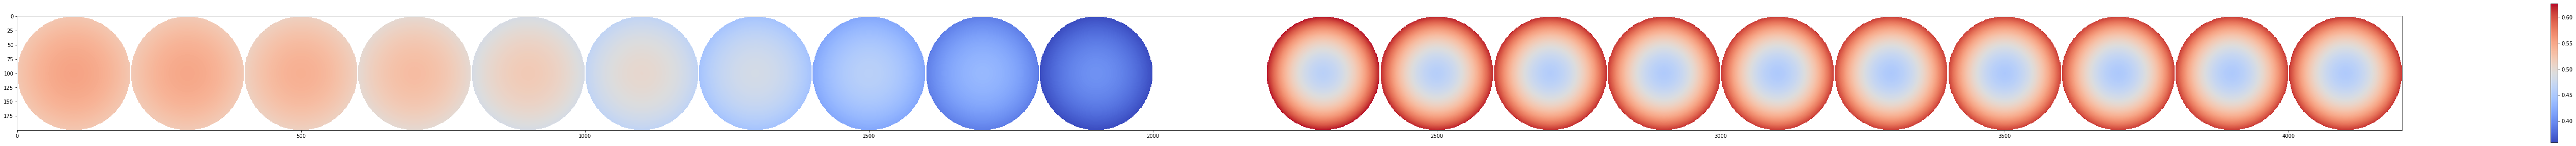

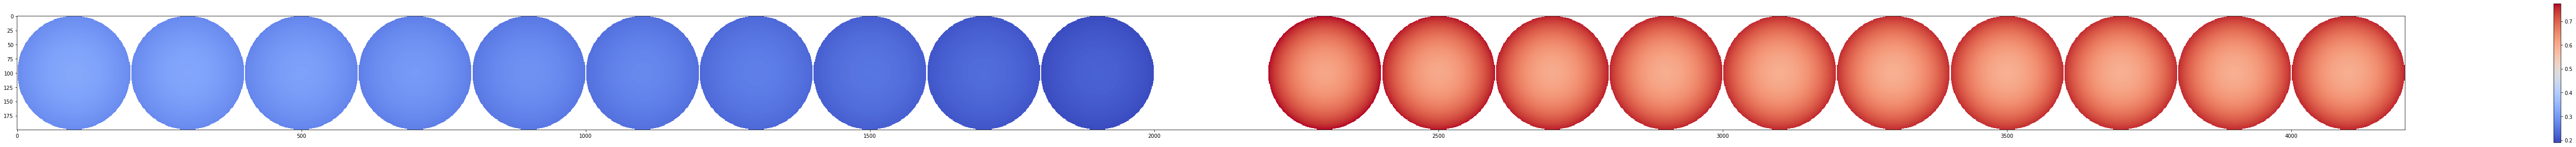

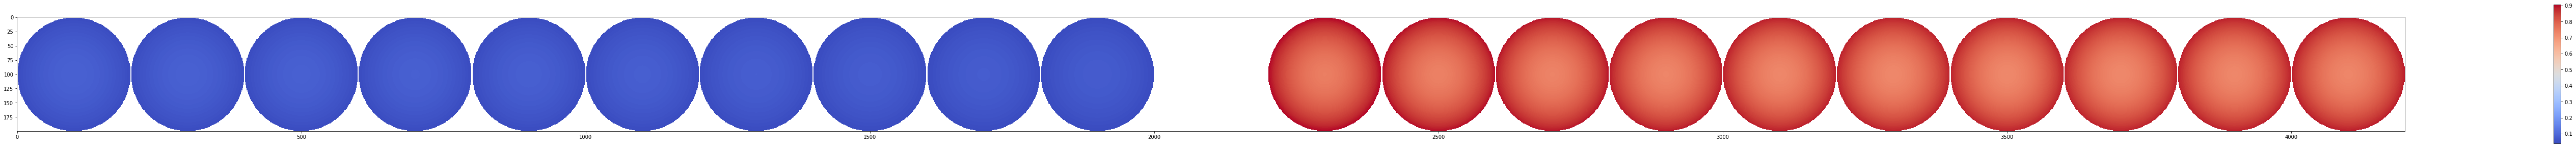

In [5]:
for tstep in [25, 50, 75, 98]:
    C_n = solution["Negative particle concentration"].entries[:, :, tstep].T
    C_p = solution["Positive particle concentration"].entries[:, :, tstep].T
    C_s = C_n[:1, :] * np.nan
    dom = np.vstack((C_n[: : 3, :], C_s, C_p[: : 3, :]))
    plot_particles(dom)